# Estimation of effective connectivity (EC) based on a dynamic following a multivariate Ornstein-Uhlenbeck (MOU) process
## Replication of results from the paper by [Senden et al. (2017)](#references) for validation purposes
This Python notebook aims to reproduce the results presented in the abovementioned paper. As the fundamental approach utilized in the paper matches exactly the one applied in a closely related project by Gilson et al. (ct. [MOUEC-Estimation notebook by Gilson et al. (2019)](#references)), the code is heavily influenced by and partly taken from this source (explicit indications are not provided in this provisional version). For comparability purposes most content is used in original form with adaptations only where necessary. The class MOU (multivariate Ornstein-Uhlenbeck) from the [*pyMOU* library](#references) (pymou.mou_model), which is used in that project, was adapted to match the procedure described in the paper (slightly different process model). The changes exclusively effect the method fit_LO().

The files/folders listed below are required to be positioned in the same location the main file *replicate_results_from_Senden_et_al_paper.ipynb* is located. 
- *mou_model.py* (The adapted version of the eponymous file from the [*pyMOU* library](#references).)
- *DATA_TASK_3DMOV_HP_CSF_WD.mat* (BOLD time series (funtional data) and ROI lables.)
- *BINARY_EC_MASK.mat* (Anatomical connectome averaged over subjects (binary structural data).)
- *images_from_paper (Folder conntaining the (qualitatively) reproduced results from [Senden et al. (2017)](#references).)*

In [1]:
## Import dependencies.
import os
import itertools
from scipy.io import loadmat, savemat, matlab
import scipy.stats as stt
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=False)
from matplotlib.ticker import FormatStrFormatter
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mou_model import MOU
from load_mat import load_mat
from calculate_FC_with_constant_timeseries_length import \
    calculate_FC_with_constant_timeseries_length
## Check whether simple_colors is installed, otherwise install using pip
try:
    from simple_colors import * # for printing colored and bold text
except:
    ! pip install simple_colors

## Import simple_colors
from simple_colors import *

%matplotlib inline
    
## Flags
io_based_on_nodal_degree_flag = True
allow_all_connections_for_EC_flag = False
optimize_with_FC_version = 'FC_avg' #'FC_scaled_avg','FC_avg_scaled','FC_avg'
plot_FC_scaled_avg_flag = False # If == False, FC_avg_scaled is printed
input_is_rowsum_flag = False # If == False, input = columnsum
save_EC_flag = True # If == True, EC is calculated and saved, else loaded

## Introduce constants.
_FIGURES_DIR = 'reprodued_figures'
_RES_DIR = str('model_parameter ' + 
    optimize_with_FC_version +
    '/')
_I_REST_RUN = 0
_I_NBACK_RUN = 1
_I_NO_TIMESHIFT = 0
_I_ONE_TIMESHIFT = 1
_SUBJECT_AXIS = 0

## Create a local folder to store the results.
if not os.path.exists(_RES_DIR):
    print('created directory:', _RES_DIR)
    os.makedirs(_RES_DIR)
if not os.path.exists(_FIGURES_DIR):
    print('created directory:', _FIGURES_DIR)
    os.makedirs(_FIGURES_DIR)

### Data set
The data set consists of 5 sessions for 14 subjects: one each for rest, the n-back task, the flanker task, the mental rotation task, and the odd-man out task. Each session is about 6 minutes long and consists of 192 time points (fMRI time resolution TR = 2 seconds). The parcellation corresponds to the Desikan-Killany (DK) atlas with 68 regions of interest (ROIs).
The preprocessed fMRI data is available as described in the Paper of interest ([Senden et al. (2017)](#references)) and was downloaded from https://datadryad.org/stash/dataset/doi:10.5061/dryad.mc7pd. For more detailed information concerning the data follow the link above or see said paper.

The data files are:
 - *DATA_TASK_3DMOV_HP_CSF_WD.mat* (BOLD time series (funtional data) and ROI lables)
 - *BINARY_EC_MASK.mat* (anatomical connectome averaged over subjects (binary structural data))

As the data format of the preprocessed data is different from the one in the aforementioned notebook by Gilson ([MOUEC-Estimation notebook by Gilson et al. (2019)](#references)), it is restructured to match the format of the latter for enhanced comparability.

In [2]:
## Read in data and structure it.
fMRI_data_and_labels = load_mat(
    'BOLD_data_and_SC_matrix/DATA_TASK_3DMOV_HP_CSF_WD')
keys_1st_layer = list(fMRI_data_and_labels.keys())
regionalized_preprocessed_fMRI_data = fMRI_data_and_labels[keys_1st_layer[3]]
roi_labels = fMRI_data_and_labels[keys_1st_layer[4]]
run_labels = list(regionalized_preprocessed_fMRI_data.keys())
first_run_data = regionalized_preprocessed_fMRI_data[run_labels[0]]


# Display the ROI labels.
print('\nR'+'\u0332'+'egions O'+'\u0332'+'f I'+'\u0332'+'nterest (ROIs): \n')
for i,i_roi in enumerate(roi_labels): 
    print(f'{i:2d} : {i_roi}')
# Extract the fMRI data properties.
n_subjects = first_run_data.shape[2]
n_runs = len(regionalized_preprocessed_fMRI_data)
n_rois = first_run_data.shape[1]
n_ts_samples = first_run_data.shape[0]
# Restructure data.
filtered_ts_emp = np.zeros([n_subjects, n_runs, n_rois, n_ts_samples])
for i,i_run in enumerate(run_labels):
    filtered_ts_emp[:, i, :, :] = np.transpose(
        regionalized_preprocessed_fMRI_data[i_run], (2, 1, 0))

The data in BOLD_data_and_SC_matrix/DATA_TASK_3DMOV_HP_CSF_WD consists of 2 elements with the following keys:

TASKEC
	containing another dictionary with the keys
	 Rest
		containing an array
			of shape (192, 68, 14) 
			and dtype float64
	 nBack
		containing an array
			of shape (192, 68, 14) 
			and dtype float64
	 Flanker
		containing an array
			of shape (192, 68, 14) 
			and dtype float64
	 mRotation
		containing an array
			of shape (192, 68, 14) 
			and dtype float64
	 OddManOut
		containing an array
			of shape (192, 68, 14) 
			and dtype float64
ROIlbls
		containing an array
			of shape (68,) 
			and dtype object

R̲egions O̲f I̲nterest (ROIs): 

 0 : lh_bankssts
 1 : lh_caudalanteriorcingulate
 2 : lh_caudalmiddlefrontal
 3 : lh_cuneus
 4 : lh_entorhinal
 5 : lh_fusiform
 6 : lh_inferiorparietal
 7 : lh_inferiortemporal
 8 : lh_isthmuscingulate
 9 : lh_lateraloccipital
10 : lh_lateralorbitofrontal
11 : lh_lingual
12 : lh_medialorbitofrontal
13 : lh_middletemporal
14 : lh_par

### Functional connectivity (FC)
As the BOLD covariances "are natural objective functions for the MOU model," ([MOUEC-Estimation notebook by Gilson et al. (2019)](#references)) they are used as  functional connectivity here. The BOLD time series are zero-centered in order to eliminate offset differences between runs.

Due to the scaling most of the FC values should be between 0 and 1
Min FC0 value: -0.0633170659963744
Mean FC0 value: 0.27782975509697455
Max FC0 value: 2.2258443501672893
Mean BOLD variance (diagonal of each FC0 matrix): 0.8533317073767986


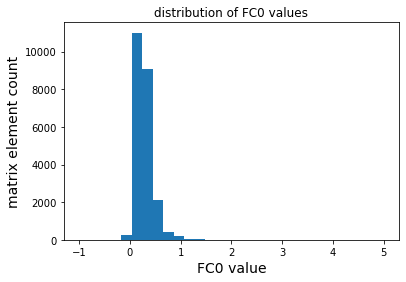

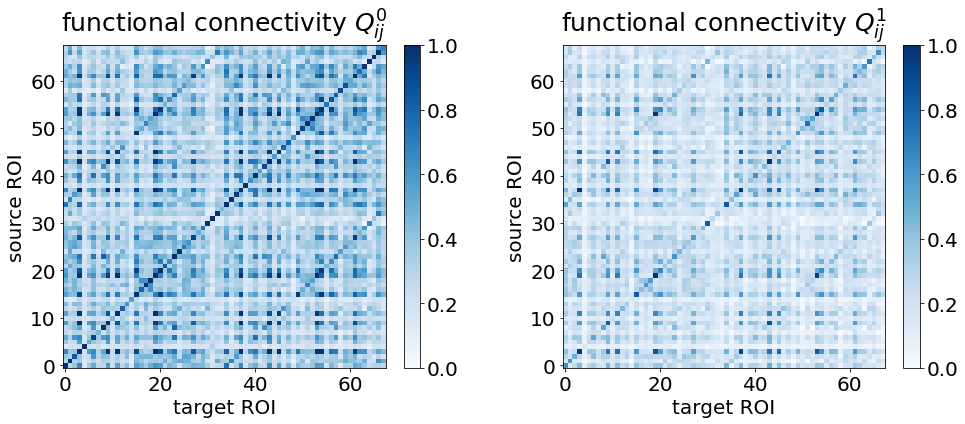



	Original FC-matrixes from Senden et al. (2017) (FIGURE 2(e))


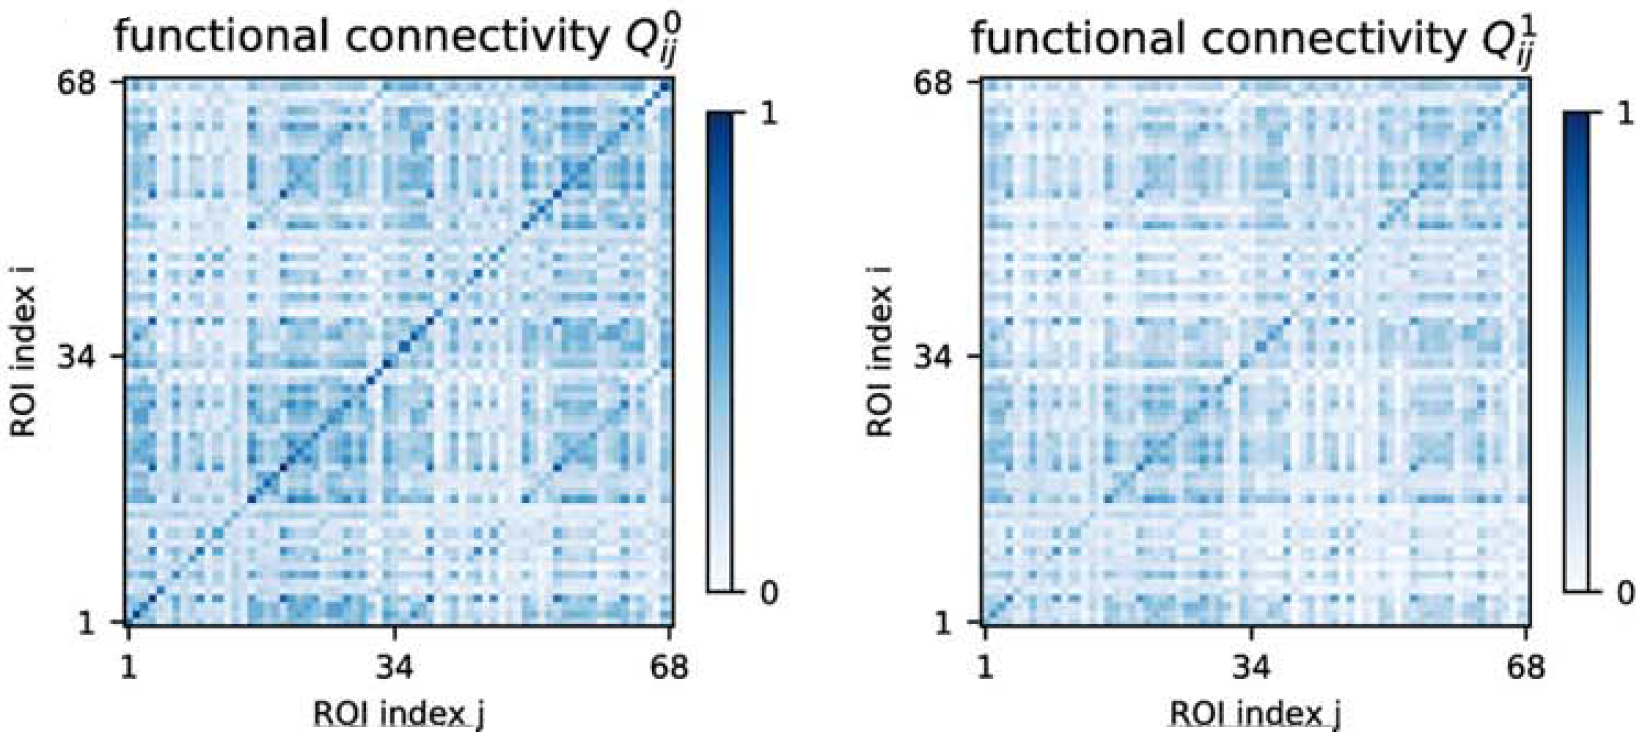

In [3]:
## Reproduce FIGURE 2(e) of the Senden et al. (2017) paper.
# Calculate functional connectivity (BOLD covariances) [Q0 and Q1].
time_shifts = np.arange(2, dtype=int)
n_shifts = len(time_shifts)
FC = calculate_FC_with_constant_timeseries_length(filtered_ts_emp, n_shifts)
# Scale FC with the inverse of the mean of the rest-run-, no-timeshift-
# autocovariances.
FC_scaled = FC / FC[:, _I_REST_RUN, _I_NO_TIMESHIFT, :,
                    :].diagonal(axis1=1, axis2=2).mean()
# Average FC over subjects.
FC_avg = FC.mean(axis=_SUBJECT_AXIS)
FC_scaled_avg = FC_scaled.mean(axis=_SUBJECT_AXIS)
# Scale FC avg with the inverse of the mean of the rest-run-, no-timeshift- 
# autocovariances.
FC_avg_scaled = FC_avg / FC_avg[_I_REST_RUN, _I_NO_TIMESHIFT, :,
                            :].diagonal(axis1=0, axis2=1).mean()

# Show distibution of FC0 values.
if plot_FC_scaled_avg_flag:
    plotted_FC_version = FC_scaled_avg
else:
    plotted_FC_version = FC_avg_scaled
print('Due to the scaling most of the FC values should be between 0 and 1')
print('Min FC0 value:', 
      plotted_FC_version[:, _I_NO_TIMESHIFT, :, :].min())
print('Mean FC0 value:', 
      plotted_FC_version[:, _I_NO_TIMESHIFT, :, :].mean())
print('Max FC0 value:', 
      plotted_FC_version[:, _I_NO_TIMESHIFT, :, :].max())
print('Mean BOLD variance (diagonal of each FC0 matrix):', 
      plotted_FC_version[:, _I_NO_TIMESHIFT, :, :].diagonal(
          axis1=1, axis2=2).mean())
plt.figure()
plt.hist(plotted_FC_version[:, _I_NO_TIMESHIFT, :, :].flatten(),
         bins=np.linspace(-1, 5, 30))
plt.xlabel('FC0 value', fontsize=14)
plt.ylabel('matrix element count', fontsize=14)
plt.title('distribution of FC0 values')
plt.show()

# Show FC0 averaged over subjects for the rest run.
title_fontsize = 25
fontsize = 20
fig = plt.figure(figsize=(14, 6))
plt.subplot(121)
FC0_rest = plotted_FC_version[_I_REST_RUN, _I_NO_TIMESHIFT, :, :]
ax = plt.gca()
im = ax.imshow(FC0_rest, origin='lower', cmap='Blues', vmin=0, vmax=1)
devider = make_axes_locatable(ax)
cax = devider.append_axes('right', size='5%', pad=0.25)
cbar = plt.colorbar(im, cax=cax)
ax.set_xlabel('target ROI', fontsize=fontsize)
ax.set_ylabel('source ROI', fontsize=fontsize)
ax.set_title('functional connectivity $Q_{ij}^0$', fontsize=title_fontsize)
ax.tick_params(axis="x", labelsize=fontsize)
ax.tick_params(axis="y", labelsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

# Show FC1 averaged over subjects for the rest run.
plt.subplot(122)
FC1_rest = plotted_FC_version[_I_REST_RUN, _I_ONE_TIMESHIFT, :, :]
ax = plt.gca()
im = ax.imshow(FC1_rest, origin='lower', cmap='Blues', vmin=0, vmax=1)
devider = make_axes_locatable(ax)
cax = devider.append_axes('right', size='5%', pad=0.25)
cbar = plt.colorbar(im, cax=cax)
ax.set_xlabel('target ROI', fontsize=fontsize)
ax.set_ylabel('source ROI', fontsize=fontsize)
ax.set_title('functional connectivity $Q_{ij}^1$', fontsize=title_fontsize)
ax.tick_params(axis="x", labelsize=fontsize)
ax.tick_params(axis="y", labelsize=fontsize)
plt.subplots_adjust(left=0.15, right=1, wspace=0.4)
cbar.ax.tick_params(labelsize=fontsize)
plt.show()
fig.savefig(str(_FIGURES_DIR + '/FC_matrixes.pdf'), bbox_inches='tight')

# Display the FC-matixes from the Senden-paper (cf. FIGURE 2e))
print(black('\n\n\tOriginal FC-matrixes from Senden et al. (2017)'
            ' (FIGURE 2(e))', 'bold'))
Image(filename = "images_from_paper/figure2e_FC_matrixes_fixed.png",
      width=1000, height=1000)

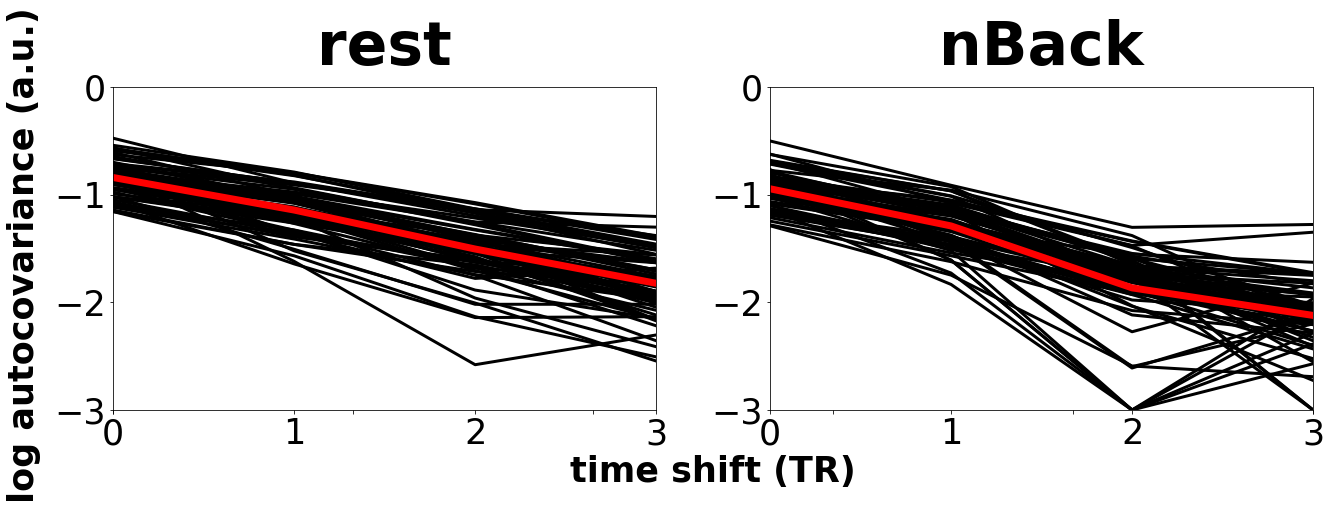



	Original graphic from Senden et al. (2017) (FIGURE 2(b))


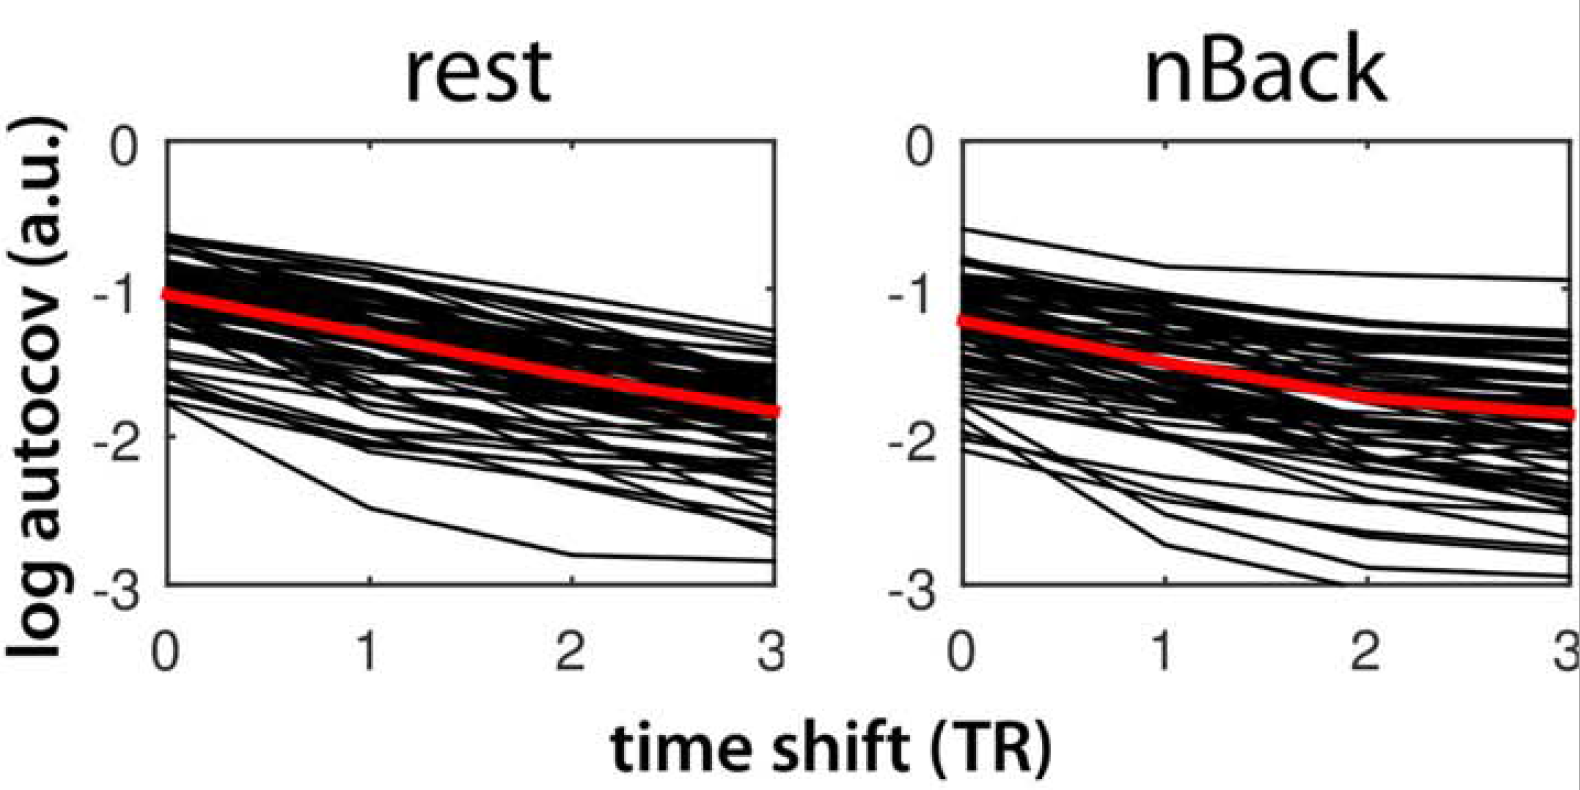

In [4]:
## Reproduce FIGURE 2(b) of the Senden et al. (2017) paper.
# Plot the logarithm of the mean (over subjects) autocovariance for the 
#  first 3 time shifts.

# Plot parameters.
ylim = -3
suptitle_fontsize = 25
title_fontsize = 60
axis_lable_fontsize = 35
linewidth = 3
fat_linewidth = 7

# Calculate FC with 0, 1, 2, 3 timeshifts.
n_shifts = 4
FC_4_shifts = calculate_FC_with_constant_timeseries_length(
    filtered_ts_emp, n_shifts)
FC_4_shifts_avg = FC_4_shifts.mean(axis=_SUBJECT_AXIS)

# Calculate the logarithm of the autocovariance. 
ac = FC_4_shifts_avg[:, :, :, :].diagonal(axis1=2, axis2=3)
log_ac = np.log10(np.maximum(ac[:, :, :], pow(10, ylim)))

# Show the autocovariance for the rest run.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8),
                       sharex=True, sharey=True)
plt.subplot(121)
plt.plot(range(n_shifts), log_ac[_I_REST_RUN,:,:], '-k', linewidth=linewidth)
plt.plot(range(n_shifts), log_ac[_I_REST_RUN, :, :].mean(axis=1),
         '-r', linewidth=fat_linewidth)
plt.title('rest', fontsize=title_fontsize, y=1.05, weight='bold')
plt.ylim((ylim, 0))
plt.xlim((0, n_shifts-1))
ax = plt.gca()
ax.tick_params(axis="x", labelsize=axis_lable_fontsize)
ax.tick_params(axis="y", labelsize=axis_lable_fontsize)

# Show the autocovariance for the nBack run.
plt.subplot(122)
plt.plot(range(n_shifts), log_ac[_I_NBACK_RUN,:,:], '-k', linewidth=linewidth)
plt.plot(range(n_shifts), log_ac[_I_NBACK_RUN,:,:].mean(axis=1),
         '-r', linewidth=fat_linewidth)
plt.title('nBack', fontsize=title_fontsize, y=1.05, weight='bold')
plt.ylim((ylim, 0))
plt.xlim((0, n_shifts-1))
ax = plt.gca()
ax.tick_params(axis="x", labelsize=axis_lable_fontsize)
ax.tick_params(axis="y", labelsize=axis_lable_fontsize)
plt.subplots_adjust(left=0.15, right=1, wspace=0.6)
# Add a big axes and hide frame for joint y- and x-label.
ax = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', left=False, right=False)
plt.xlabel("time shift (TR)", fontsize=axis_lable_fontsize, weight='bold')
plt.ylabel("log autocovariance (a.u.)",
           fontsize=axis_lable_fontsize, weight='bold')
ax.xaxis.set_label_coords(0.5,-0.14)
ax.yaxis.set_label_coords(-0.06,0.48)
plt.tight_layout()
plt.show()
fig.savefig(str(_FIGURES_DIR + '/autocovariances.pdf'), bbox_inches='tight')

# Display log(autocovariances) from the Senden-paper (cf. FIGURE 2b))
print(black('\n\n\tOriginal graphic from Senden et al. (2017) (FIGURE 2(b))',
            'bold'))
Image(filename = "images_from_paper/figure2b_14zu7_fixed.png", width=1000,
      height=1000)

### Structural connectivity (SC)
The SC-matrix can be found at http://dutchconnectomelab.nl/ under the title 'Group-averaged binary connectivity matrix based on 50 healthy subjects. Data as used in the paper "Edge-centric perspective on the human connectome: link communities in the brain", De Reus et al. 2014, Philosophical Transactions of the Royal Society B. Oct 5;369(1653).' in the download section. Although this matrix is not the one used in the paper ([Senden et al. (2017)](#references)), it looks like the best alternative, for the paper does not provide a reference to the original matrix.

Typically, structural connectivity indicates 'the probability or the density of white-matter projections between pairs of ROIs in the parcellation. The algorithm that fits the model to the functional data (BOLD signals) only uses the information about whether there is a connection or not between two ROIs, to decide whether the corresponding weight is optimized.' ([MOUEC-Estimation notebook by Gilson et al. (2019)](#references)) So, the downloaded binary matrix is completely sufficient for the purpose of reproducing the results from the abovementioned paper.

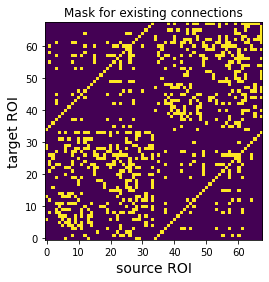

In [5]:
## Include structural connectivity.
mask_EC = np.array(loadmat('BOLD_data_and_SC_matrix/BINARY_EC_MASK.mat')
                   ['grouped_umcu50_60percent'], dtype=bool)
# Enforce inter-hermispheric connections.
for i in range(int(n_rois/2)):
    mask_EC[i, int(n_rois/2)+i] = True
    mask_EC[int(n_rois/2)+i, i] = True
# Visualise the binary structural connectivity mask.
plt.figure()
plt.imshow(mask_EC, origin='lower')
plt.xlabel('source ROI', fontsize=14)
plt.ylabel('target ROI', fontsize=14)
plt.title('Mask for existing connections', fontsize=12)
plt.show()

if allow_all_connections_for_EC_flag:
    mask_EC = None

### MOU-EC estimation
'The optimization procedure tunes the parameters of the MOU model, namely the directional connectivity ($C$, referred to as MOU-EC) and the input covariance ($\Sigma$). It is a gradient descent that aims to minimize the matrix distance between the model and empirical covariances (referred to as spatiotemporal FC). In practice, it is encapsulated in the *fit* method of the *MOU* class. For a tutorial of the use of the MOU class for simulation and estimation, check the [*MOU_Simulation_Estimation* notebook](#references).' ([MOUEC-Estimation notebook by Gilson et al. (2019)](#references))

'The optimization algorithm works with learning rates for the connectivity and the input covariance ($\epsilon_C$ and $\epsilon_\Sigma$). If they are too fast, the fitting procedure may end up being stuck in a worse local minimum than what is achievable with smaller learning rates.' ([MOUEC-Estimation notebook by Gilson et al. (2019)](#references)) For the paper (ct. [Senden et al. (2017)](#references)) the rates are set to $\epsilon_C = 0.001$ and $\epsilon_\Sigma = 0.1$. For quicker but less finely graduated otimization try $\epsilon_C = 0.001$ and $\epsilon_\Sigma = 0.1$ with `mou_model.fit_LO(FC[i_run], i_tau_opt, mask_C=mask_EC mask_Sigma=mask_Sigma, epsilon_C=0.001, epsilon_Sigma=0.1)`.

All parameters/restrictions not explicitly passed to the fit_LO@MOU method, have the correct defaults in fit_LO@MOU. As opposed to the procedure in [MOUEC-Estimation notebook by Gilson et al. (2019)](#references) instead of calling fit@MOU and passin the BOLD-timeseries, fit_LO is called directly with the FC matrixes. This is due to the fact that in fit@MOU the calculation of FC0 (no-time-shift covariances) and FC1 (1-TR-time-shift covariances) are calculated not exactly as described in [Senden et al. (2017)](#references) (with varying timeseries legth instead of constand length as described in said paper).

Depending on the value of $\epsilon_C$ the following cell might take some minutes ($\epsilon_C$ = 0.0001) to run through.

In [6]:
## Calculate EC-matrixes.
if save_EC_flag:
    # Run the model optimization.
    # Initialize the source arrays.
    
    # Jacobian (off-diagonal elements = EC):
    J_mod = np.zeros([n_runs, n_rois, n_rois])
    # Noise variance matrix (input covariance, forced to be diagonal
    # (no input cross-correlation) through mask_Sigma):
    Sigma_mod = np.zeros([n_runs, n_rois, n_rois])
    # Model error: Matrix distance between the empirical objective
    # covariances and their model counterparts
    # (normalized for each objective matrix):
    dist_mod = np.zeros([n_runs])
    # Squared Pearson correlation between the empirical objective
    # covariances and the model counterpart:
    R2_mod = np.zeros([n_runs])
    # The between-region EC matrix of the model:
    C_mod = np.zeros([n_runs, n_rois, n_rois])

    if optimize_with_FC_version == 'FC_scaled_avg':
        FC = FC_scaled_avg
    elif optimize_with_FC_version == 'FC_avg_scaled':
        FC = FC_avg_scaled
    elif optimize_with_FC_version == 'FC_avg':
        FC = FC_avg
    else:
        print("!!!WARNING: Invalid Expression for the flag\
        'optimize_with_scaled_FC'!!! Valid terms are\n\
        'FC_scaled_avg', 'FC_avg_scaled', 'FC_avg' (default).")
        FC = FC_avg
    print('Optimize based on', str(optimize_with_FC_version + '.'))

    # Run the estimation of model parameters for all sessions.
    mask_Sigma = np.eye(n_rois, dtype=bool) # Mask for input noise matrix.
    C = np.zeros([n_rois, n_rois])
    mou_model = MOU(C=C) # Pass C in order to make n_nodes known to MOU().
    for i_run in range(n_runs):
        mou_model.fit_LO(FC[i_run], mask_Sigma=mask_Sigma, mask_C=mask_EC)
        # Organize the optimization results into arrays.
        J_mod[i_run, :, :] = mou_model.J
        Sigma_mod[i_run, :, :] = mou_model.Sigma
        dist_mod[i_run] = mou_model.d_fit['distance']
        R2_mod[i_run] = mou_model.d_fit['correlation']**2
        C_mod[i_run, :, :] = mou_model.get_C()

        print('run:', run_labels[i_run], ';\t model error, R2:',
              dist_mod[i_run], R2_mod[i_run])

    # Store the results.
    np.save(_RES_DIR + 'FC_emp.npy',
            FC)  # Empirical spatiotemporal FC
    np.save(_RES_DIR + 'mask_EC.npy',
            mask_EC)  # Mask of optimized connections
    np.save(_RES_DIR + 'mask_Sigma.npy',
            mask_Sigma)  # Mask of optimized Sigma elements
    np.save(_RES_DIR + 'Sigma_mod.npy',
            Sigma_mod)  # Estimated Sigma matrices
    np.save(_RES_DIR + 'dist_mod.npy',
            dist_mod)  # Model error
    np.save(_RES_DIR + 'J_mod.npy',
            J_mod)  # Estimated Jacobian, EC + inverse time const. on diag.
    print('\nFinished.')

## Load EC- and noise variance matrixes.
else:
    Sigma_mod = np.load(_RES_DIR + 'Sigma_mod.npy')
    J_mod = np.load(_RES_DIR + 'J_mod.npy')
    C_mod = np.copy(J_mod)
    C_mod[:, range(n_rois), range(n_rois)] = 0

Optimize based on FC_avg.
tau_x: 1.434371988900544
run: Rest ;	 model error, R2: 0.405787927167065 0.6378435465350344
tau_x: 1.2579955752997327
run: nBack ;	 model error, R2: 0.44010016656315015 0.6275327153820636
tau_x: 1.2905913787184946
run: Flanker ;	 model error, R2: 0.4923994360863425 0.5349934061895246
tau_x: 1.1761600222683384
run: mRotation ;	 model error, R2: 0.5212954362960404 0.551052887653045
tau_x: 1.1681292003985535
run: OddManOut ;	 model error, R2: 0.44280264459469554 0.6209534094077622

Finished.


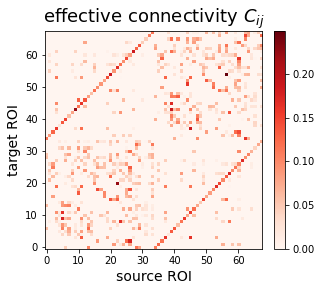



Original EC-matrix from Senden et al. (2017) (FIGURE 2(e))


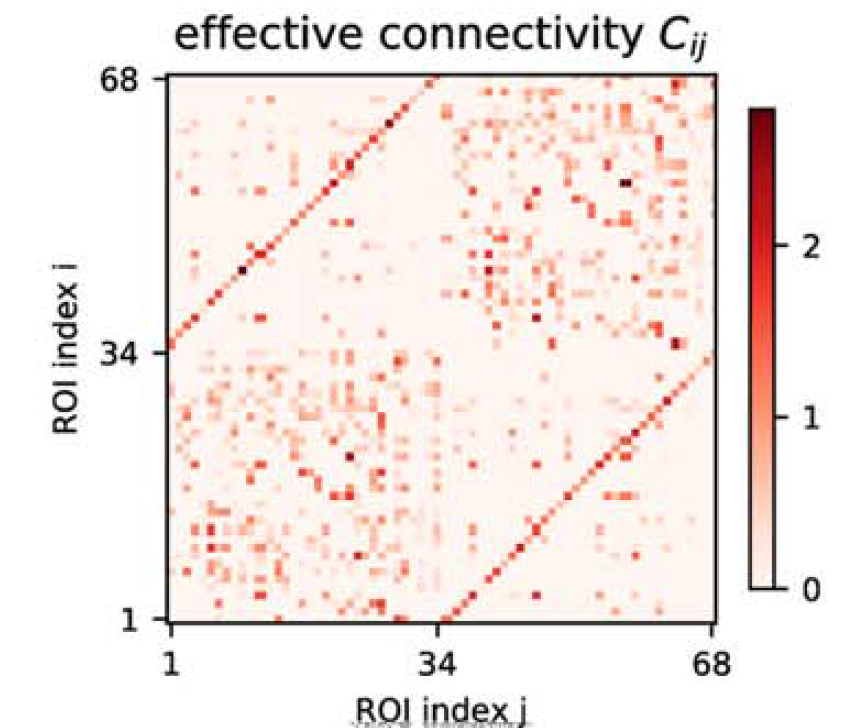

In [7]:
## Reproduce FIGURE 2(e) of the Senden et al. (2017) paper.
# Plot C-matrix for resting state data.
fig = plt.figure()
plt.imshow(C_mod[_I_REST_RUN, :, :], origin='lower', cmap='Reds')
plt.colorbar(pad=0.035)
plt.xlabel('source ROI', fontsize=14)
plt.ylabel('target ROI', fontsize=14)
plt.title('effective connectivity $C_{ij}$', fontsize=18)
plt.show()
fig.savefig(str(_FIGURES_DIR + '/EC.pdf'), bbox_inches='tight')

# Display the EC-matrix from the Senden-paper (FIGURE 2e))
print(black('\n\nOriginal EC-matrix from Senden et al. (2017) (FIGURE 2(e))',
            'bold'))
Image(filename = "images_from_paper/figure2e_EC_matrix.png",
      width=350, height=350)

### Local variability
As in the paper, local variability ($\Sigma$) is split up into the part exhibited by the rich club and the one exhibited by the peripheral regions. All analyses of the local variability are based on the investigated group of rois' (rc and periphery) mean variability.

In [8]:
## Calculate local variability for rich club and periphery.
mask_rc = np.zeros(n_rois, dtype=bool) # 1D-mask for rich club regions.
indexes_rich_club = [23, 26, 27, 57, 60, 61]
mask_rc[indexes_rich_club] = True
print('Rich club regions:\n',
      roi_labels[indexes_rich_club].tolist())
local_var = Sigma_mod[:, :, :].diagonal(axis1=1, axis2=2)
rc_var = local_var[:, mask_rc]
periph_var = local_var[:, ~mask_rc]
mean_rc_var = rc_var.mean(axis=1) # Avarage over regions.
mean_periph_var = periph_var.mean(axis=1) # Avarage over regions.
conf_int_rc = np.array(stt.t.interval(
    0.95, rc_var.shape[1]-1, loc=mean_rc_var, 
    scale=stt.sem(rc_var, axis=1))).T
conf_int_periph = np.array(stt.t.interval(
    0.95, periph_var.shape[1]-1, loc=mean_periph_var, 
    scale=stt.sem(periph_var, axis=1))).T
print('Mean of local variability (rich club):\n', str(mean_rc_var))
print('Mean of local variability (periphery):\n', str(mean_periph_var))
print('95% confidence interval (rich club):\n', conf_int_rc)
print('95% confidence interval (periphery):\n', conf_int_periph)

Rich club regions:
 ['lh_precuneus', 'lh_superiorfrontal', 'lh_superiorparietal', 'rh_precuneus', 'rh_superiorfrontal', 'rh_superiorparietal']
Mean of local variability (rich club):
 [0.02709003 0.02672205 0.02689528 0.03063514 0.03263643]
Mean of local variability (periphery):
 [0.11008928 0.11116381 0.11847845 0.12533177 0.12053525]
95% confidence interval (rich club):
 [[0.01224137 0.04193869]
 [0.01685902 0.03658508]
 [0.01116239 0.04262817]
 [0.01818867 0.0430816 ]
 [0.01716855 0.0481043 ]]
95% confidence interval (periphery):
 [[0.09149287 0.12868568]
 [0.0905852  0.13174242]
 [0.09788019 0.13907671]
 [0.10348719 0.14717635]
 [0.09856584 0.14250466]]


In [9]:
## Cluster-based bootstrapping according to section 2.5
#  of the Senden et al. (2017) paper (to investigate significance of choice  
#  of RC on mean local variability).
n_samples = 10000
length_of_sample = len(indexes_rich_club)
roi_indexes = np.arange(n_rois)

sigma_samples = np.zeros([n_runs, n_samples])

for i_run in range(n_runs):
    for i_sample in range(n_samples):
        i_index_sample = np.random.choice(
            roi_indexes, size=len(indexes_rich_club))
        mask_i_sample = np.zeros(n_rois, dtype=bool)
        mask_i_sample[i_index_sample] = True
        sigma_samples[i_run, i_sample] = local_var[i_run,
                                                   mask_i_sample].mean()

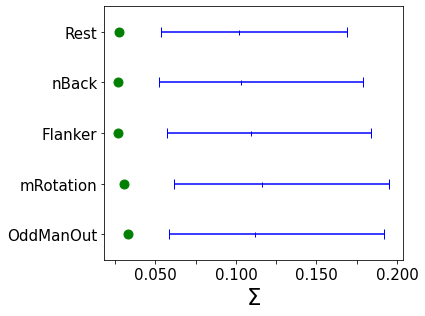



	Original graphic from Senden et al. (2017) (FIGURE 3(a))


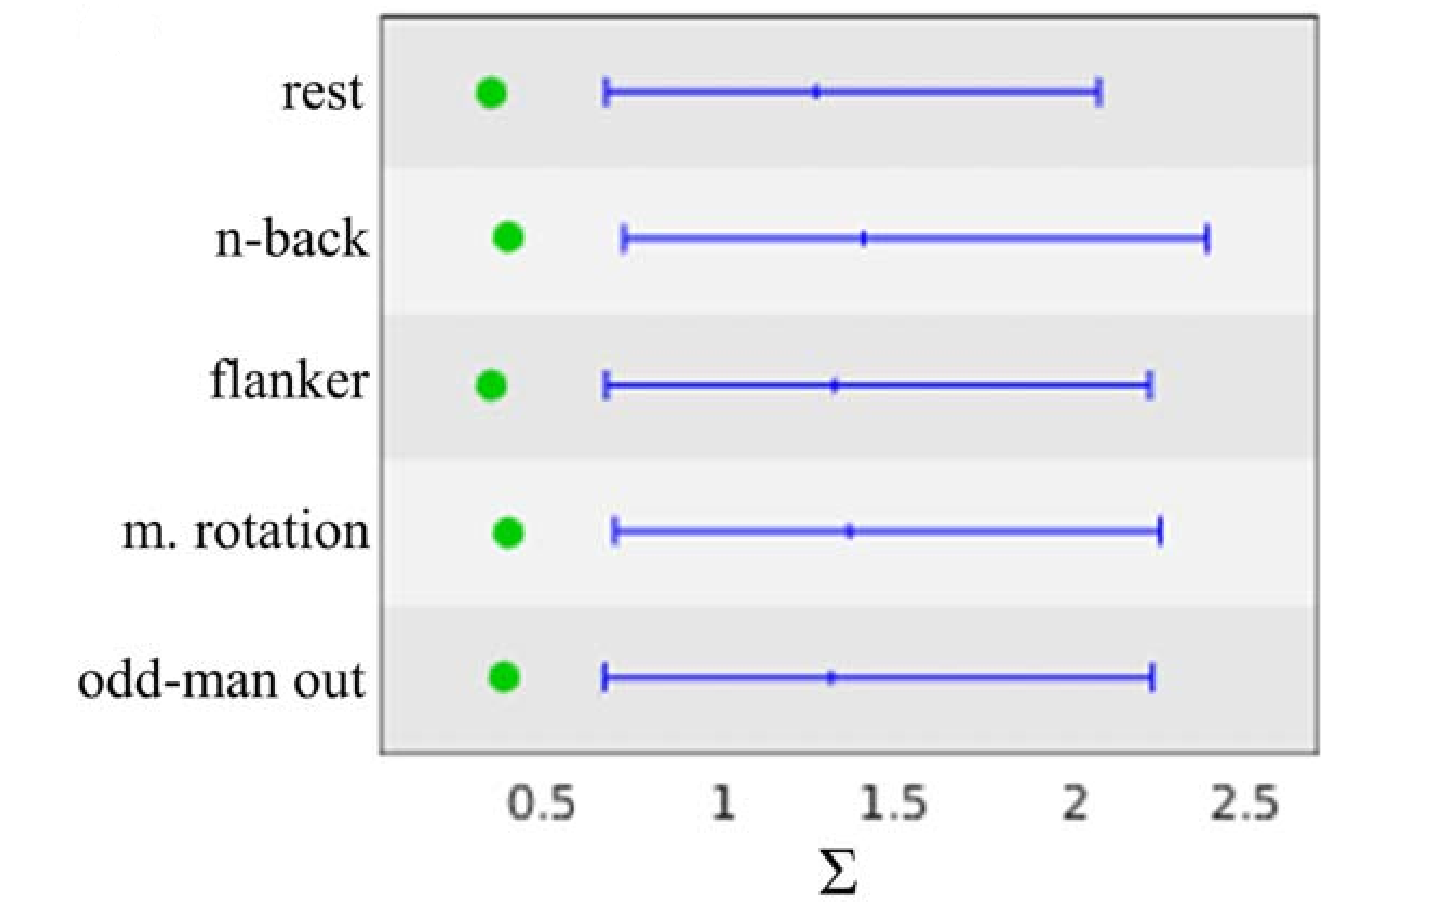

In [10]:
## Reproduce FIGURE 3(a) of the Senden et al. (2017) paper.
# Investigate significance of choice of RC regions on the mean local variance.
alpha = 0.95 # alpha percentile
lower_limit = int(np.floor(n_samples * (1 - alpha) / 2))
upper_limit = int(np.floor(n_samples * (1 + alpha) / 2))
rankordered_samples = np.sort(sigma_samples)
rankordered_samples = rankordered_samples[:, lower_limit:upper_limit]
xerr = rankordered_samples[:,[0,-1]].T

y = np.linspace(n_runs, 1, n_runs)
fontsize = 15
title_fontsize = 23
markersize = 18

fig = plt.figure(figsize=(6, 4.5))
plt.hlines(y, xmin=xerr[0, :], xmax=xerr[1, :], color='b')
plt.plot(xerr.T, y, '|', color='b', markersize=10)
plt.plot(rankordered_samples.mean(axis=1), y, '|', color='b', markersize=5)
plt.yticks(y, run_labels, fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.setp(plt.gca().get_xticklabels()[1::2], visible=False)
#ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.ylim([0.5, 5.5])
plt.xlabel('$\Sigma$', fontsize=title_fontsize, weight='bold')
mask_outside_ci = mean_rc_var > xerr.T[:,1]
mask_outside_ci[mean_rc_var < xerr.T[:,0]] = True
formatstring = mask_outside_ci.astype(np.str)
formatstring[mask_outside_ci] = '.g'
formatstring[~mask_outside_ci] = '.r'
plt.plot(*[elem for triple in [[i,j,k] for i,j,k in zip(
    mean_rc_var,y,formatstring)] for elem in triple], markersize=markersize)
plt.tight_layout()
plt.show()
fig.savefig(str(_FIGURES_DIR + '/Sigma_significance.pdf'),
            bbox_inches='tight')
# Display the corresponding figure from the Senden-paper (FIGURE 3(a))
print(black('\n\n\tOriginal graphic from Senden et al. (2017) (FIGURE 3(a))',
            'bold'))
Image(filename = "images_from_paper/paper_Sigma_significance.png",
      width=500,height=500)

### Input-output ratio
The information flow between regions is encapsulated in the $C$-matrix. In order to test the hypotheses that the rich club might gate the input it receives from peripheral regions, the inter-rich-club-connections are ignored. This means that only the information flow from and to the rich club is examined when it comes to the inspection of the rich club input-output-ratio.

The input-output ratio of the periphery takes into account all inter-periphery activity (exclusively).

Mean input-to-output ratio of the rich club:
 [1.56591479 1.32461874 1.66666667 1.16388889 1.33682412]
95% confidence interval (rich club):
 [[1.15479973 1.97702984]
 [0.78669168 1.8625458 ]
 [0.63486986 2.69846348]
 [0.9265275  1.40125028]
 [0.78052421 1.89312404]]
Total income to total outcome ratio of the rich club:
 [1.46478873 1.2        1.32051282 1.11827957 1.18823529]
Mean input-to-output ratio of the priphery:
 [0.9976303  1.01534495 0.99647163 1.01073304 1.00220944]
95% confidence interval (periphery):
 [[0.9710682  1.02419239]
 [0.9563852  1.07430469]
 [0.97272284 1.02022042]
 [0.967385   1.05408109]
 [0.98444045 1.01997843]]
Total income to total outcome ratio of the priphery:
 [1. 1. 1. 1. 1.]


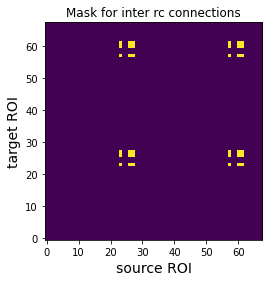

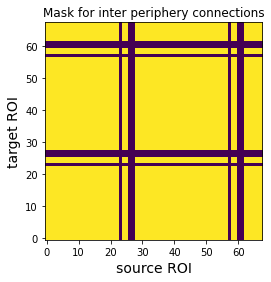

In [11]:
## Calculate the input-to-output ratio of total incoming/outgoing EC.
if input_is_rowsum_flag:
    inputAxis = 1
    outputAxis = 2
else:
    inputAxis = 2
    outputAxis = 1

# Create a 2D-mask for inter rich club connections.
mask_inter_rc = np.zeros([n_rois, n_rois], dtype=bool)
rc_ind_combin = np.array(list(
    itertools.product(indexes_rich_club, repeat=2))).T
mask_inter_rc[rc_ind_combin[0], rc_ind_combin[1]] = True

# Calculate the ratio of incoming/outgoing EC from and to the rich club
no_rc_connections_C = np.copy(C_mod)
no_rc_connections_C[:, mask_inter_rc] = 0

if io_based_on_nodal_degree_flag:
    roi_input = np.squeeze(np.count_nonzero(no_rc_connections_C,
                                            axis=inputAxis, keepdims=True))
    roi_output = np.squeeze(np.count_nonzero(no_rc_connections_C,
                                             axis=outputAxis, keepdims=True))
else:
    roi_input = no_rc_connections_C[:, :, :].sum(axis=inputAxis)
    roi_output = no_rc_connections_C[:, :, :].sum(axis=outputAxis)
io_rc = roi_input[:, mask_rc] / roi_output[:, mask_rc]

# Calculate and print the mean io-ratio and the CI for rich club regions.
mean_rc_io = io_rc[:, :].mean(axis=1)
conf_int_rc = np.array(stt.t.interval(
    0.95, io_rc.shape[1]-1, loc=io_rc.mean(axis=1), 
    scale=stt.sem(io_rc, axis=1))).T
print('Mean input-to-output ratio of the rich club:\n', str(mean_rc_io))
print('95% confidence interval (rich club):\n', str(conf_int_rc))
ratio_of_total_io_rc = (roi_input[:, mask_rc].sum(axis=1)
                        / roi_output[:, mask_rc].sum(axis=1))
print('Total income to total outcome ratio of the rich club:\n',
      str(ratio_of_total_io_rc))

# Create a 2D-mask for inter periphery connections.
mask_inter_periph = np.zeros([n_rois, n_rois], dtype=bool)
periph_ind_combin = np.array(list(itertools.product(list(
    x for x in range(n_rois) if x not in indexes_rich_club), repeat=2))).T
mask_inter_periph[periph_ind_combin[0], periph_ind_combin[1]] = True

## Calculate the ratio of incoming/outgoing EC among peripheral regions.
only_periph_connections_C = np.copy(C_mod)
only_periph_connections_C[:, ~mask_inter_periph] = 0

if io_based_on_nodal_degree_flag:
    roi_input = np.squeeze(np.count_nonzero(only_periph_connections_C,
                                            axis=inputAxis, keepdims=True))
    roi_output = np.squeeze(np.count_nonzero(only_periph_connections_C,
                                             axis=outputAxis, keepdims=True))
else:
    roi_input = only_periph_connections_C[:, :, :].sum(axis=inputAxis)
    roi_output = only_periph_connections_C[:, :, :].sum(axis=outputAxis)
io_periph = (roi_input[:, ~mask_rc] / roi_output[:, ~mask_rc])

# Calculate and print the mean io-ratio and the CI for peripheral regions
mean_periph_io = io_periph[:, :].mean(axis=1)
conf_int_periph = np.array(stt.t.interval(
    0.95, io_periph.shape[1]-1, loc=io_periph.mean(axis=1), 
    scale=stt.sem(io_periph, axis=1))).T
print('Mean input-to-output ratio of the priphery:\n', str(mean_periph_io))
print('95% confidence interval (periphery):\n', str(conf_int_periph))
ratio_of_total_io_periph = (roi_input[:, ~mask_rc].sum(axis=1)
                            / roi_output[:, ~mask_rc].sum(axis=1))
print('Total income to total outcome ratio of the priphery:\n',
      str(ratio_of_total_io_periph))

# Show the mask for inter-rc connections.
plt.figure()
plt.imshow(mask_inter_rc, origin='lower')
plt.xlabel('source ROI', fontsize=14)
plt.ylabel('target ROI', fontsize=14)
plt.title('Mask for inter rc connections', fontsize=12)
plt.show()
# Show the mask for inter periphery connections.
plt.figure()
plt.imshow(mask_inter_periph, origin='lower')
plt.xlabel('source ROI', fontsize=14)
plt.ylabel('target ROI', fontsize=14)
plt.title('Mask for inter periphery connections', fontsize=12)
plt.show()

In [12]:
## Cluster-based bootstrapping according to section 2.5
#  of the Senden et al. (2017) paper (to investigate significance of choice  
#  of RC on input-output ratio phi).
if input_is_rowsum_flag:
    inputAxis = 0
    outputAxis = 1
else:
    inputAxis = 1
    outputAxis = 0

n_samples = 10000
length_of_sample = len(indexes_rich_club)
roi_indexes = np.arange(n_rois)

phi_samples = np.zeros([n_runs, n_samples])


for i_run in range(n_runs):
    for i_sample in range(n_samples):
        i_index_sample = np.random.choice(
            roi_indexes, size=len(indexes_rich_club))
        mask_inter_sample = np.zeros([n_rois, n_rois], dtype=bool)
        sample_index_combin = np.array(list(
            itertools.product(i_index_sample, repeat=2))).T
        mask_inter_sample[sample_index_combin[0],
                          sample_index_combin[1]] = True
        # Calculate the ratio of incoming/outgoing EC from and to the sample.
        no_inter_sample_connections_C = np.copy(C_mod[i_run, :, :])
        no_inter_sample_connections_C[mask_inter_sample] = 0
        
        if io_based_on_nodal_degree_flag:
            roi_input = np.squeeze(np.count_nonzero(
                no_inter_sample_connections_C, axis=inputAxis))
            roi_output = np.squeeze(np.count_nonzero(
                no_inter_sample_connections_C, axis=outputAxis))
        else:
            roi_input = no_inter_sample_connections_C[:, :].sum(
                axis=inputAxis)
            roi_output = no_inter_sample_connections_C[:, :].sum(
                axis=outputAxis)

        mask_i_sample = np.zeros(n_rois, dtype=bool)
        mask_i_sample[i_index_sample] = True
        phi_samples[i_run, i_sample] = (roi_input[mask_i_sample].sum() /
                                    roi_output[mask_i_sample].sum())


Calculations based on nodal degree: True


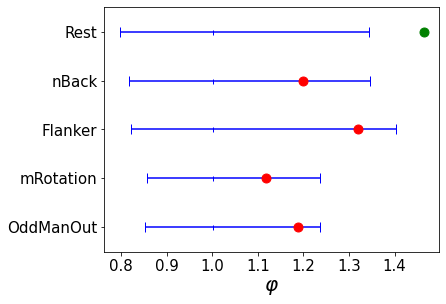



	Original graphic from Senden et al. (2017) (FIGURE 3(c))


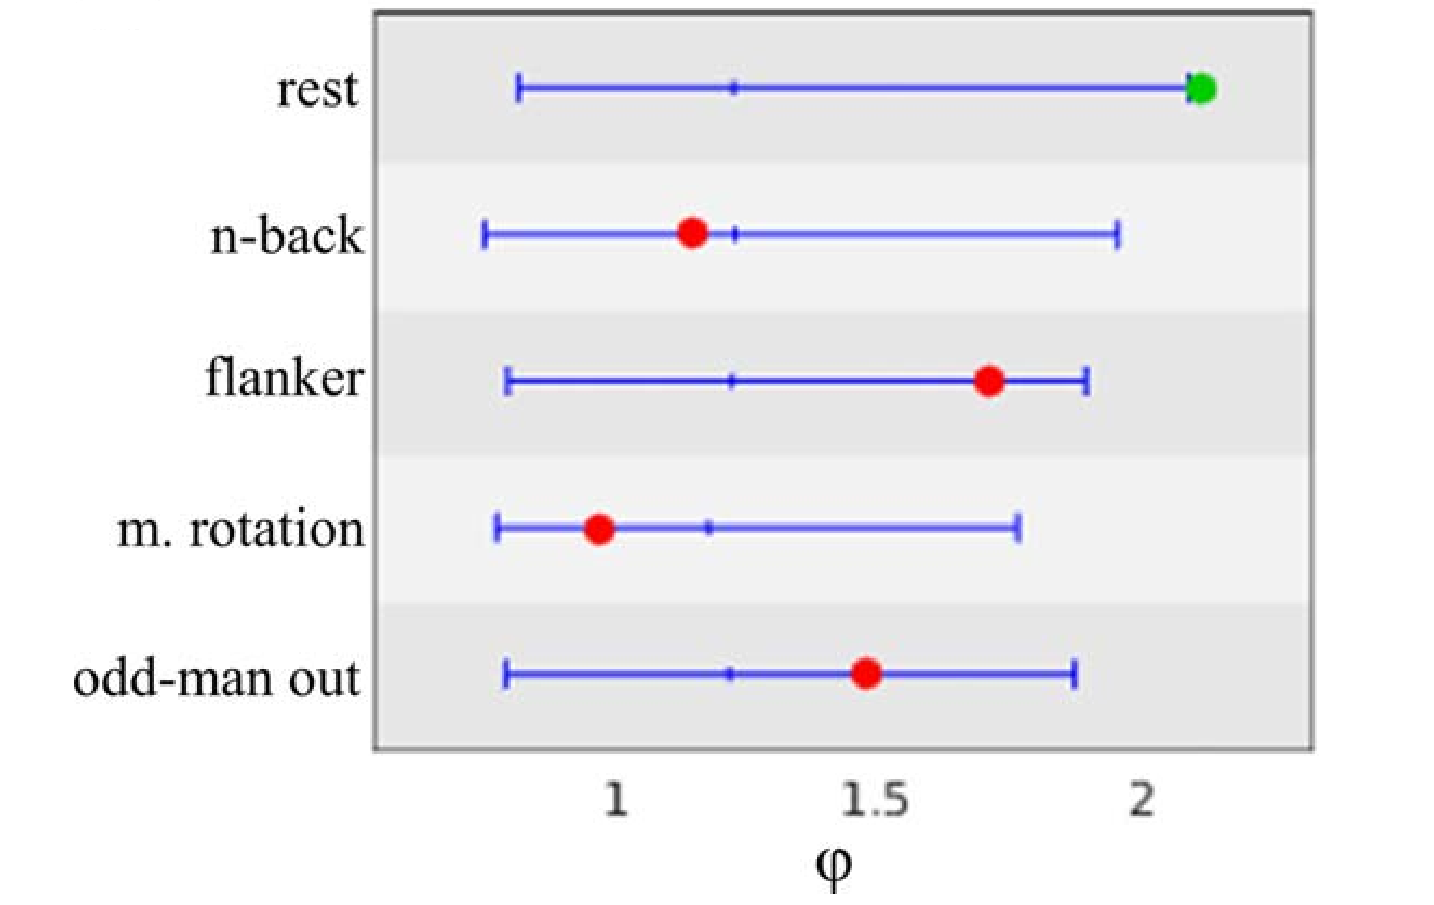

In [13]:
## Reproduce FIGURE 3(c) of the Senden et al. (2017) paper.
# Investigate significance of choice of RC regions on the input-output ratio.
# Plot CI with marks for the mean and the endpoints.
print('Calculations based on nodal degree:', io_based_on_nodal_degree_flag)
alpha = 0.995# alpha percentile
lower_limit = int(np.floor(n_samples * (1 - alpha) / 2))
upper_limit = int(np.floor(n_samples * (1 + alpha) / 2))
rankordered_samples = np.sort(phi_samples)
rankordered_samples = rankordered_samples[:, lower_limit:upper_limit]
xerr = rankordered_samples[:,[0,-1]].T
y = np.linspace(n_runs, 1, n_runs)
fontsize = 15
title_fontsize = 20
fig = plt.figure(figsize=(6, 4.5))
plt.hlines(y, xmin=xerr[0, :], xmax=xerr[1, :], color='b')
plt.plot(xerr.T, y, '|', color='b', markersize=10)
plt.plot(rankordered_samples.mean(axis=1), y, '|', color='b', markersize=5)
plt.yticks(y, run_labels, fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.ylim([0.5, 5.5])
# Plot RC io ratio (red = not significant, green = significant).
for i_run in range(n_runs):
    i_io_ratio = ratio_of_total_io_rc[i_run]
    format_string = '.r'
    if i_io_ratio > xerr.T[i_run,1] or i_io_ratio < xerr.T[i_run,0]:
        format_string = '.g' 
    plt.plot(i_io_ratio, y[i_run], format_string, markersize=18)
plt.xlabel('$\\varphi$', fontsize=title_fontsize, weight='bold')
plt.show()
fig.savefig(str(_FIGURES_DIR + '/io_significance.pdf'), bbox_inches='tight')
# Display the corresponding figure from the Senden-paper (FIGURE 3(c))
print(black('\n\n\tOriginal graphic from Senden et al. (2017) (FIGURE 3(c))',
            'bold'))
Image(filename = "images_from_paper/paper_io_significance.png",
      width=500, height=500)

# References
<a id='references'></a>
**MOUEC-Estimation notebook by Gilson et al. (2019)**: Andrea Insabato, Gorka Zamora-López, Matthieu Gilson 1_MOUEC_Estimation.ipynb. 2019. https://github.com/mb-BCA/notebooks_review2019/blob/master/1_MOUEC_Estimation.ipynb. 2021.03.26

***MOU_Simulation_Estimation*** **notebook**: Andrea Insabato, Gorka Zamora-López, Matthieu Gilson MOU_Simulation_Estimation.ipynb. 2019. https://github.com/mb-BCA/pyMOU/blob/master/examples/MOU_Simulation_Estimation.ipynb. 2021.03.26

***pyMOU*** **library**: Andrea Insabato, Gorka Zamora-López, Matthieu Gilson. 2019. https://github.com/mb-BCA/pyMOU. 2021.03.26

**Senden et al. (2017)**: M. Senden, N. Reuter, M. P. van den Heuvel, R. Goebel, G. Deco, and M. Gilson. Task-related effective connectivity reveals that the cortical rich club gates cortex-wide communication. Hum Brain Mapp, 2017. https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.23913